In [1]:

import straindesign as sd
import cobra
import pandas as pd
import numpy as np
from plotnine import *
from tqdm import tqdm

## Load the three models

In [2]:
core=cobra.io.load_json_model('ecoli_core/e_coli_core.json') #core model
iml1515=cobra.io.load_json_model('iML1515/iML1515.json') #Genome Scale Model
ich360=cobra.io.load_json_model('../Model/Escherichia_coli_iCH360.json') #Genome Scale Model

models=[core,ich360,iml1515]
model_names=['core','ich360','iml1515']

## Some simple statistics

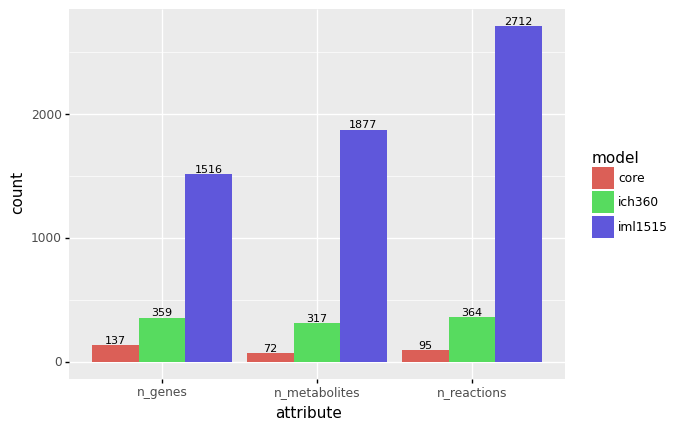

<ggplot: (-9223371909498515548)>

In [3]:
basic_stats=pd.DataFrame(index=model_names,
                    columns=['model','n_reactions','n_metabolites','n_genes'])
basic_stats['model']=model_names
basic_stats['n_reactions']=[len(model.reactions) for model in models]
basic_stats['n_genes']=[len(model.genes) for model in models]
basic_stats['n_metabolites']=[len(model.metabolites) for model in models]

#Plotting
(
ggplot(basic_stats.melt('model',var_name='attribute',value_name='count') )
+ aes(x='attribute',y='count',fill='model') 
+ geom_col(stat='identity',position='dodge')
+ geom_text(aes(label='count'),                                    # new
             position=position_dodge(width=0.9),
             size=8, va='bottom')
)

## Growth under different carbon sources and conditions

All three models behave similarly across the range of carbon source and growth conditions considered (note that not all carbon sources are available in the core model). Note that the genome scale model display is able to grow on glycerol and akg under unaerobic conditions, while iCH360 cannot.


c:\Users\marco\anaconda3\envs\met_mod2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.


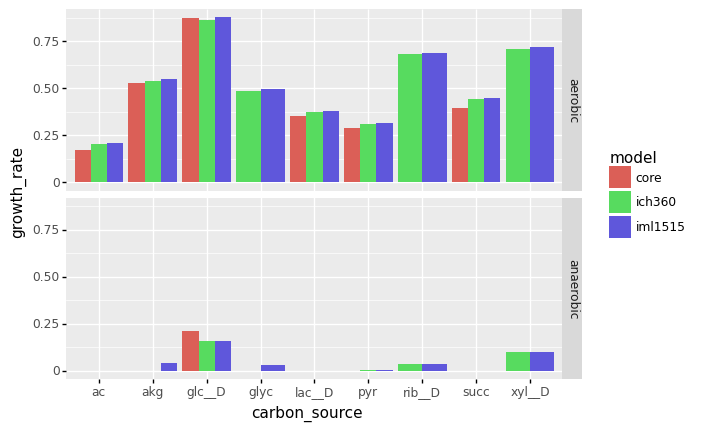

<ggplot: (-9223371909499034500)>

In [4]:
#Define carbon sources
carbon_sources=['glc__D','lac__D','ac','pyr' ,'glyc','rib__D','xyl__D','succ','akg']
exchange_fluxes=['EX_'+c_source+'_e' for c_source in carbon_sources]
conditions=['aerobic','anaerobic']
carbon_influx=10

#Compute results
results=pd.DataFrame(columns=['model','carbon_source','condition','growth_rate'])
for i,model in enumerate(models):
    for cs in carbon_sources:
        for condition in conditions:
            with model:
                exchange_rxn='EX_'+cs+'_e'
                if exchange_rxn not in model.reactions:
                    continue
                # Block default glucose exchange
                model.reactions.EX_glc__D_e.lower_bound=0
                #Block oxygen if anaerobic
                if condition=='anaerobic':
                    model.reactions.EX_o2_e.lower_bound=0
                #Set carbon source uptake and solve
                model.reactions.get_by_id(exchange_rxn).lower_bound=-carbon_influx
                sol=model.optimize()
                #Fill in result table
                new_row={'model':model_names[i],
                        'carbon_source':cs,
                        'condition':condition,
                        'growth_rate':sol.objective_value if sol.status=='optimal' else 0
                        }
                results=results.append(new_row,ignore_index=True)
                
#Visualise
(
ggplot(results)
+aes(x='carbon_source',y='growth_rate',fill='model')
+geom_col(position=position_dodge(width=0.9))
+facet_grid('condition ~ .')
)

## Production envelopes

Here, we look at production envelopes of the three models. Production envelopes are projections of the feasible space of the LP onto a specified set of dimensions. In this case, we look at biomass flux vs product flux for a range of products under aerobic and anaerobic conditions. Note that, for readability, only the perimeter of the envelopes are shown (dotted lines), but the envelope is actually the entire region enclosed by the plotted lines.

First, compute production envelopes using StrainDesign. We consider growth on glucose and use the standard 10 mmol/GDW/h uptake flux:

In [64]:
%%capture
biomass_rxns_id={'core':'BIOMASS_Ecoli_core_w_GAM','ich360':'RBIO','iml1515':'BIOMASS_Ec_iML1515_core_75p37M'}
products=['EX_etoh_e','EX_ac_e','EX_lac__D_e','EX_succ_e']
conditions=['aerobic','anaerobic']
envelopes={model_name:{
                     condition: {product:0 
                                for product in products 
                                }
                     for condition in conditions
                    } 
        for model_name in model_names}

for i,model in (enumerate(models)):
    model_name=model_names[i]
    for condition in conditions:
        for product in tqdm(products):
            if condition=='anaerobic':
                dp,tr,plot=sd.plot_flux_space(model,(biomass_rxns_id[model_name],product),constraints=['EX_o2_e=0'],show=False)
            else:
                dp,tr,plot=sd.plot_flux_space(model,(biomass_rxns_id[model_name],product),show=False)
            envelopes[model_name][condition][product]=(dp,tr,plot)

Visualise them

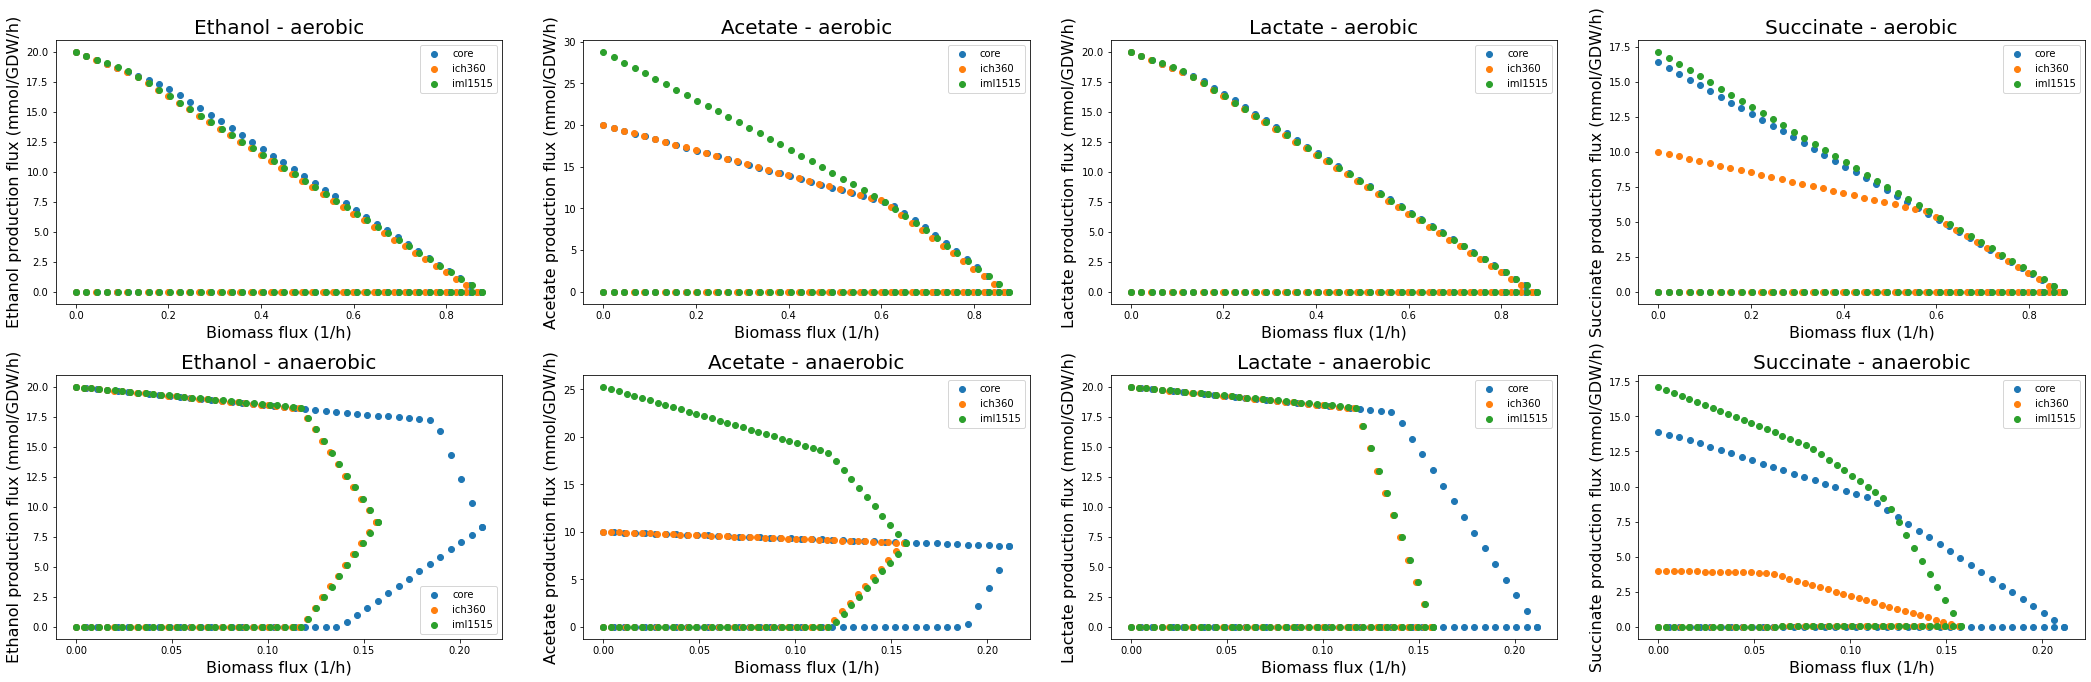

In [65]:
import matplotlib.pyplot as plt
from matplotlib import patches

fig,ax=plt.subplots(len(conditions),len(products),figsize=(30,10))
plt.tight_layout(pad=5)
product_names=['Ethanol','Acetate','Lactate','Succinate']
for i,condition in enumerate(conditions):
    for j,product in enumerate(products):
        for k,model_name in enumerate(model_names):
            cur_envelope=np.array(envelopes[model_name][condition][product][0])
            ax[i,j].scatter(cur_envelope[:,0],cur_envelope[:,1])
            ax[i,j].set_title(product_names[j]+' - '+condition,fontsize=20)
            ax[i,j].set_xlabel('Biomass flux (1/h)',fontsize=16)
            ax[i,j].set_ylabel(product_names[j]+' production flux (mmol/GDW/h)',fontsize=16)
            ax[i,j].legend(model_names)

Something is happening with succinate in the medium-scale model: Need to look into that!